# cyberdatascience.org

---



Data acquisition

In [ ]:
import shutil
import urllib.request as request
from contextlib import closing

with closing(request.urlopen('ftp://ftp.sei.cmu.edu/pub/cert-data/r4.2.tar.bz2')) as r:
    with open('r4.2.tar.bz2', 'wb') as f:
        shutil.copyfileobj(r, f)
!bzip2 -d r4.2.tar.bz2
!!tar xvf r4.2.tar

In [12]:
import numpy as np
import pandas as pd
path_to_dataset = "data/r4.2/"
log_types = ["device", "email", "file", "logon", "http"]
log_fields_list = [
    ["date", "user", "activity"],
    ["date", "user", "to", "cc", "bcc"],
    ["date", "user", "filename"],
    ["date", "user", "activity"],
    ["date", "user", "url"],
]
features = 0
feature_map = {}


def add_feature(name):
    """Add a feature to a dictionary to be encoded."""
    if name not in feature_map:
        global features
        feature_map[name] = features
        features += 1

Data Selection and Feature Engineering

In [13]:
add_feature("Weekday_Logon_Normal")
add_feature("Weekday_Logon_After")
add_feature("Weekend_Logon")
add_feature("Logoff")

add_feature("Connect_Normal")
add_feature("Connect_After")
add_feature("Connect_Weekend")
add_feature("Disconnect")

add_feature("Email_In")
add_feature("Email_Out")

add_feature("File_exe")
add_feature("File_jpg")
add_feature("File_zip")
add_feature("File_txt")
add_feature("File_doc")
add_feature("File_pdf")
add_feature("File_other")

add_feature("url")

def file_features(row):
    """Creates a feature recording the file extension of the file used."""
    if row["filename"].endswith(".exe"):
        return feature_map["File_exe"]
    if row["filename"].endswith(".jpg"):
        return feature_map["File_jpg"]
    if row["filename"].endswith(".zip"):
        return feature_map["File_zip"]
    if row["filename"].endswith(".txt"):
        return feature_map["File_txt"]
    if row["filename"].endswith(".doc"):
        return feature_map["File_doc"]
    if row["filename"].endswith(".pdf"):
        return feature_map["File_pdf"]
    else:
        return feature_map["File_other"]


def email_features(row):
    """Creates a feature recording whether an email has been sent externally."""
    outsider = False
    if not pd.isnull(row["to"]):
        for address in row["to"].split(";"):
            if not address.endswith("dtaa.com"):
                outsider = True

    if not pd.isnull(row["cc"]):
        for address in row["cc"].split(";"):
            if not address.endswith("dtaa.com"):
                outsider = True

    if not pd.isnull(row["bcc"]):
        for address in row["bcc"].split(";"):
            if not address.endswith("dtaa.com"):
                outsider = True
    if outsider:
        return feature_map["Email_Out"]
    else:
        return feature_map["Email_In"]


def device_features(row):
    """Creates a feature for whether the user has connected during normal hours or otherwise."""
    if row["activity"] == "Connect":
        if row["date"].weekday() < 5:
            if row["date"].hour >= 8 and row["date"].hour < 17:
                return feature_map["Connect_Normal"]
            else:
                return feature_map["Connect_After"]
        else:
            return feature_map["Connect_Weekend"]
    else:
        return feature_map["Disconnect"]


def logon_features(row):
    """Creates a feature for whether the user logged in during normal hours or otherwise."""
    if row["activity"] == "Logon":
        if row["date"].weekday() < 5:
            if row["date"].hour >= 8 and row["date"].hour < 17:
                return feature_map["Weekday_Logon_Normal"]
            else:
                return feature_map["Weekday_Logon_After"]
        else:
            return feature_map["Weekend_Logon"]
    else:
        return feature_map["Logoff"]


def http_features(row):
    """Encodes the URL visited."""
    return feature_map["url"]


def date_to_day(row):
    """Converts a full datetime to date only."""
    day_only = row["date"].date()
    return day_only

log_feature_functions = [
    device_features,
    email_features,
    file_features,
    logon_features,
    http_features,
]

In [14]:
dfs = []
for i in range(len(log_types)):
    log_type = log_types[i]
    log_fields = log_fields_list[i]
    log_feature_function = log_feature_functions[i]
    df = pd.read_csv(
        path_to_dataset + log_type + ".csv", usecols=log_fields, index_col=None
    )
    date_format = "%m/%d/%Y %H:%M:%S"
    df["date"] = pd.to_datetime(df["date"], format=date_format)

    new_feature = df.apply(log_feature_function, axis=1)
    df["feature"] = new_feature

    cols_to_keep = ["date", "user", "feature"]
    df = df[cols_to_keep]

    df["date"] = df.apply(date_to_day, axis=1)

    dfs.append(df)

# 21 min

Data processing

In [15]:
joint=pd.concat(dfs)
joint=joint.sort_values(by="date")
threat_actors=["AAM0658","AJR0932","BDV0168","BIH0745","BLS0678","BTL0226","CAH0936","DCH0843","EHB0824","EHD0584","FMG0527","FTM0406","GHL0460","HJB0742","JMB0308","JRG0207","KLH0596","KPC0073","LJR0523","LQC0479","MAR0955","MAS0025","MCF0600","MYD0978","PPF0435","RAB0589","RGG0064","RKD0604","TAP0551","WDD0366","AAF0535","ABC0174","AKR0057","CCL0068","CEJ0109","CQW0652","DIB0285","DRR0162","EDB0714","EGD0132","FSC0601","HBO0413","HXL0968","IJM0776","IKR0401","IUB0565","JJM0203","KRL0501","LCC0819","MDH0580","MOS0047","NWT0098","PNL0301","PSF0133","RAR0725","RHL0992","RMW0542","TNM0961","VSS0154","XHW0498","BBS0039","BSS0369","CCA0046","CSC0217","GTD0219","JGT0221","JLM0364","JTM0223","MPM0220","MSO0222",]

In [16]:
# start_date = joint["date"].iloc[0]
# end_date = joint["date"].iloc[-1]
# time_horizon = (end_date - start_date).days + 1

# def vectorize_dataset(df):
#     """Takes the dataset and featurizes it."""
#     users = set(df["user"].values)
#     X = np.zeros((len(users), len(feature_map), time_horizon))
#     y = np.zeros((len(users)))
#     for index, user in enumerate(users):
#         x = vectorize_user_time_series(user, df)
#         X[index, :, :] = x
#         y[index] = int(user in threat_actors)
#     return X, y


# def date_to_index(date):
#     """Indexes dates by counting the number of days since the starting date of the dataset."""
#     return (date - start_date).days

# def extract_time_series_by_user(user_name, df):
#     """Filters the dataframe down to a specific user."""
#     return df[df["user"] == user_name]


# def vectorize_user_time_series(user_name, df):
#     """Convert the sequence of features of a user to a vector-valued time series."""
#     user_time_series = extract_time_series_by_user(user_name, df)
#     x = np.zeros((len(feature_map), time_horizon))
#     event_date_indices = user_time_series["date"].apply(date_to_index).to_numpy()
#     event_features = user_time_series["feature"].to_numpy()
#     for i in range(len(event_date_indices)):
#         x[event_features[i], event_date_indices[i]] += 1
#     return x

# X, y = vectorize_dataset(joint)

# # 75 min

In [56]:
import numpy as np
import pandas as pd

# Assuming 'joint' is your main DataFrame and 'feature_map' is defined elsewhere
start_date = joint["date"].iloc[0]
end_date = joint["date"].iloc[-1]
time_horizon = (end_date - start_date).days + 1

def preprocess_data(df):
    """Preprocesses the data to map users to their data."""
    user_groups = df.groupby('user')
    return {user: group for user, group in user_groups}

def vectorize_dataset(df, user_data):
    """Takes the dataset and featurizes it."""
    users = list(user_data.keys())
    X = np.zeros((len(users), len(feature_map), time_horizon))
    y = np.zeros(len(users))
    for index, user in enumerate(users):
        x = vectorize_user_time_series(user, user_data[user])
        X[index, :, :] = x
        y[index] = int(user in threat_actors)
    return X, y

def date_to_index(date):
    """Indexes dates by counting the number of days since the starting date of the dataset."""
    return (date - start_date).days

def vectorize_user_time_series(user_name, user_df):
    """Convert the sequence of features of a user to a vector-valued time series."""
    x = np.zeros((len(feature_map), time_horizon))
    event_date_indices = user_df["date"].apply(date_to_index).to_numpy()
    event_features = user_df["feature"].to_numpy()
    for i in range(len(event_date_indices)):
        x[event_features[i], event_date_indices[i]] += 1
    return x

# Preprocess data
user_data = preprocess_data(joint)
X, y = vectorize_dataset(joint, user_data)


In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(750, 18, 501)
(750,)
(250, 18, 501)
(250,)


In [58]:
X_train_reshaped = X_train.reshape(
    [X_train.shape[0], X_train.shape[1] * X_train.shape[2]]
)
X_test_reshaped = X_test.reshape([X_test.shape[0], X_test.shape[1] * X_test.shape[2]])
X_train_normal = X_train_reshaped[y_train == 0, :]
print(X_train_normal.shape)
X_train_threat = X_train_reshaped[y_train == 1, :]
print(X_train_threat.shape)
X_test_normal = X_test_reshaped[y_test == 0, :]
print(X_test_normal.shape)
X_test_threat = X_test_reshaped[y_test == 1, :]
print(X_test_threat.shape)

(697, 9018)
(53, 9018)
(233, 9018)
(17, 9018)


Choosing a model and hyper param

observe training and testing results

In [59]:
from sklearn.ensemble import IsolationForest

contamination_parameter = 0.035
IF = IsolationForest(
    n_estimators=100, max_samples=256, contamination=contamination_parameter
)

Text(0.5, 1.0, 'Distribution of anomaly score for non threats')

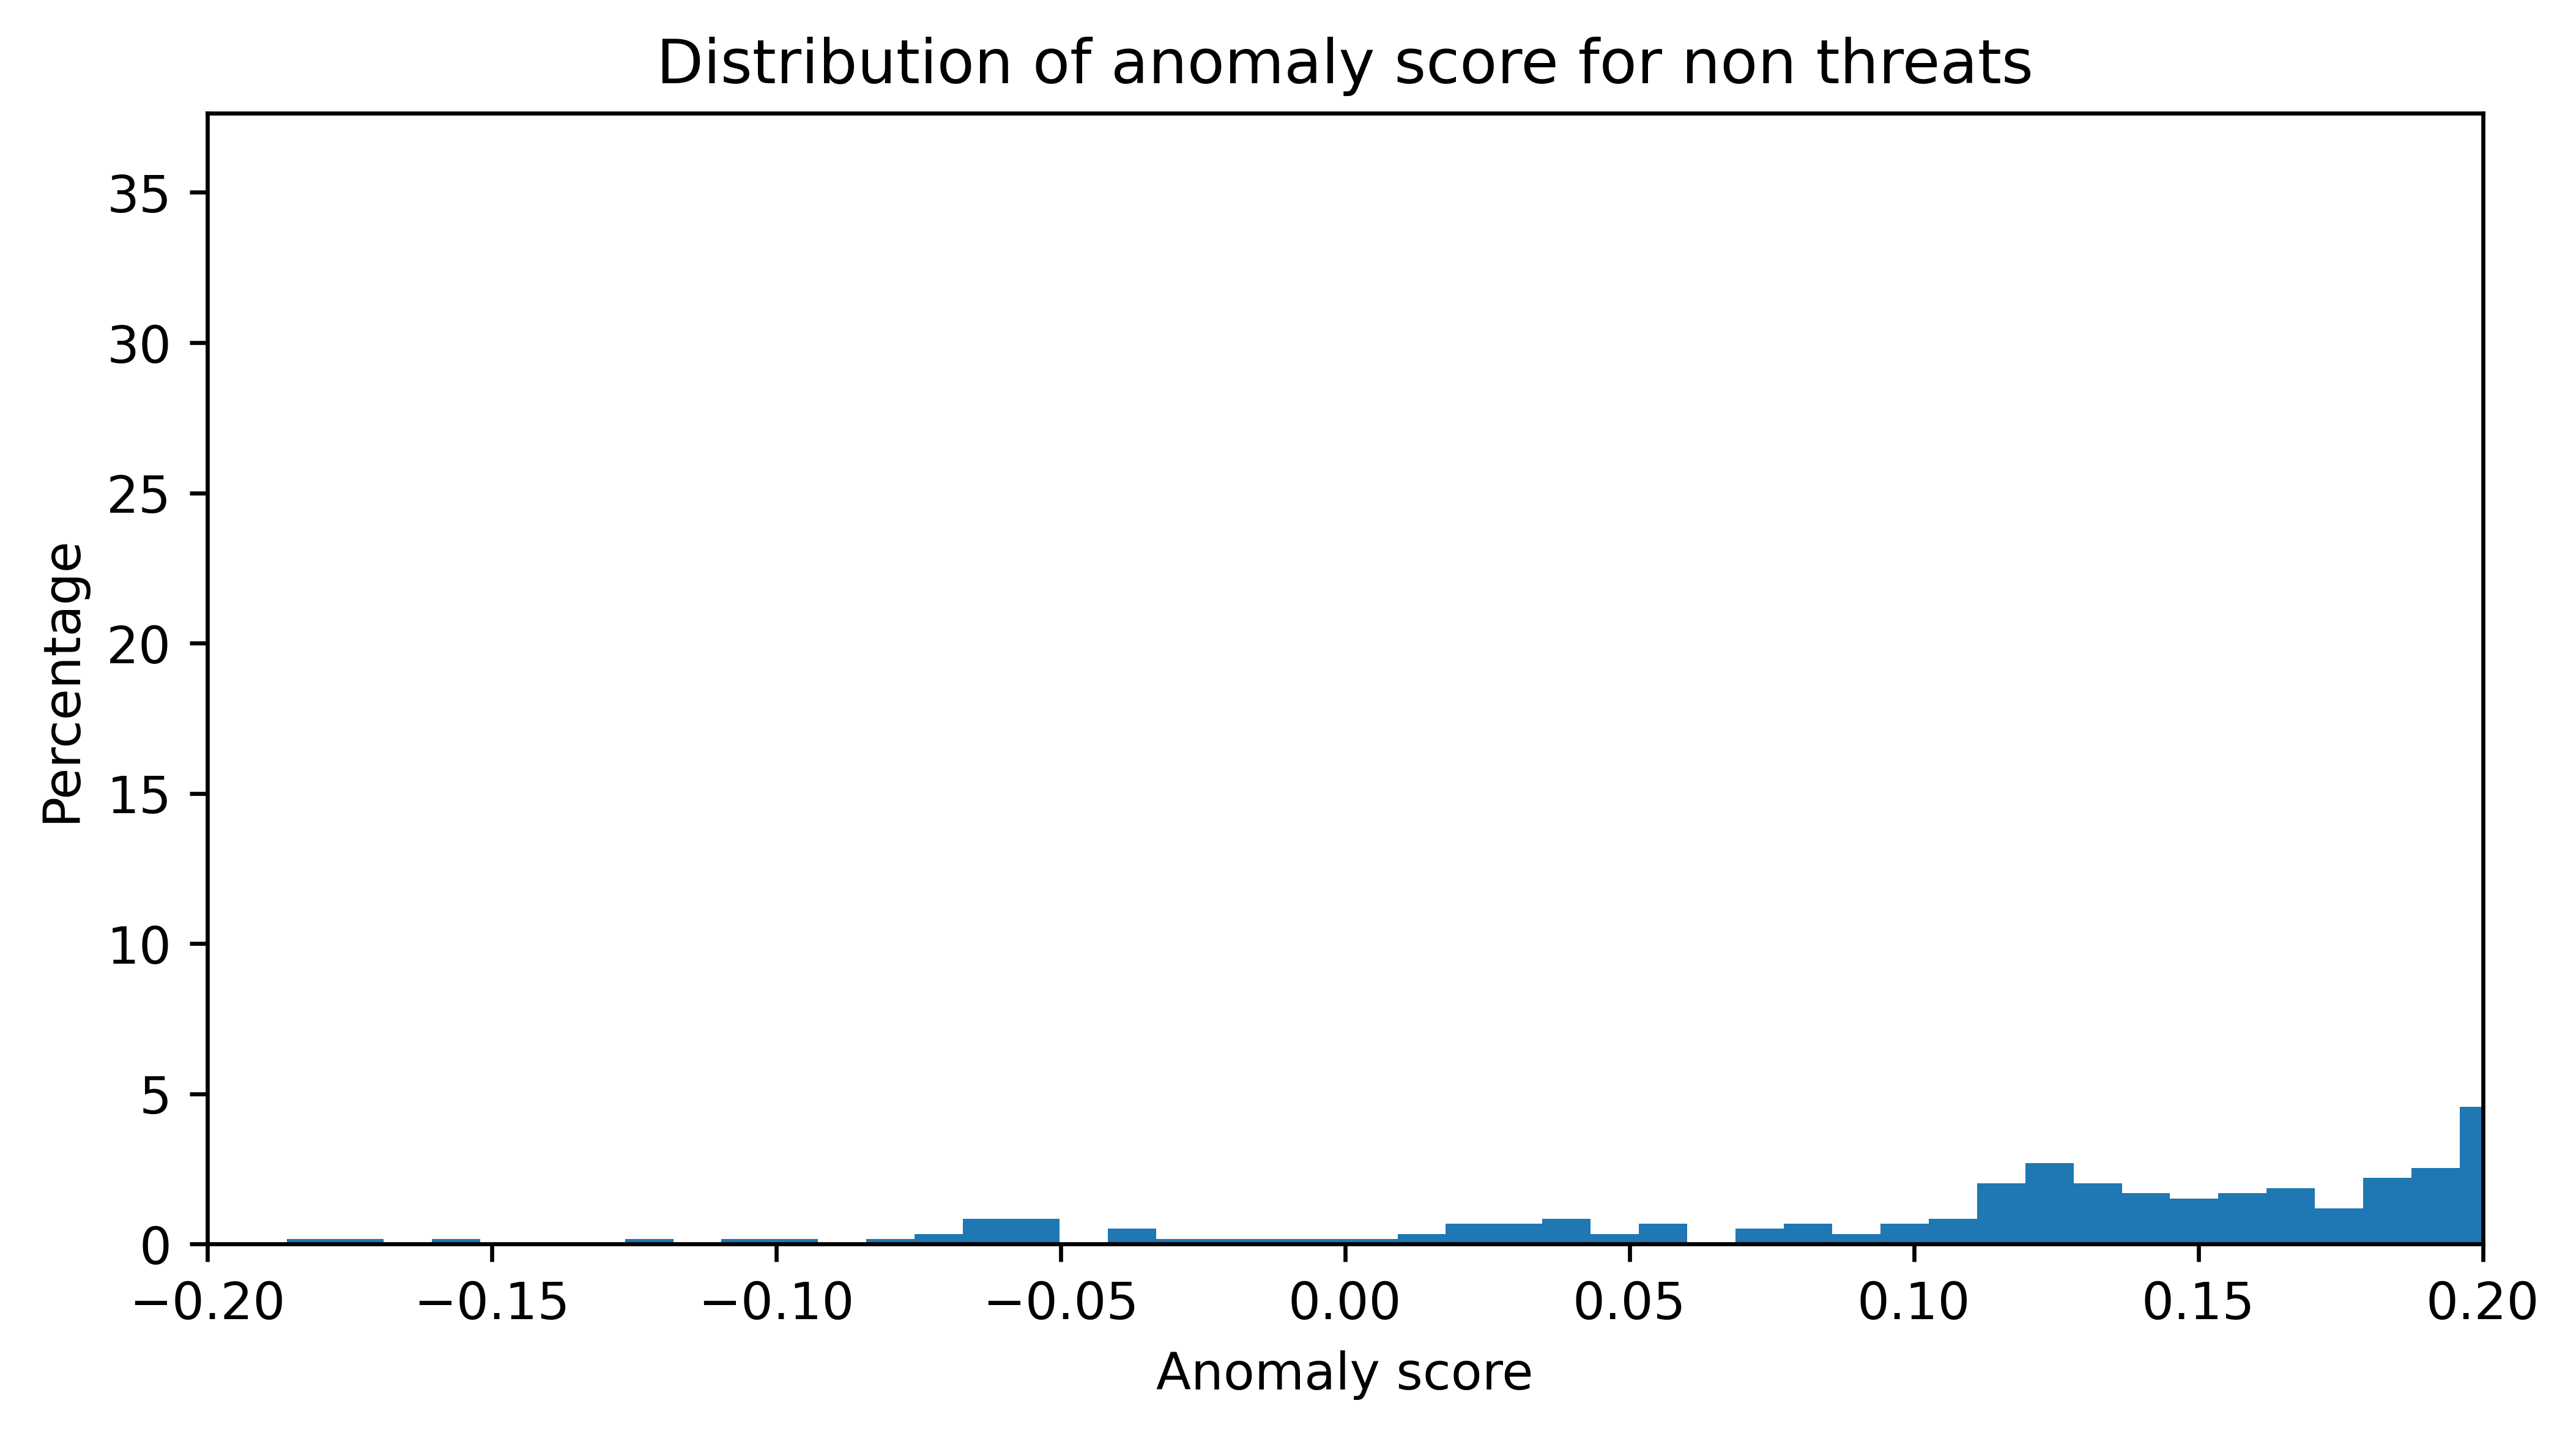

In [60]:
IF.fit(X_train_reshaped)
normal_scores = IF.decision_function(X_train_normal)

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4), dpi=600, facecolor="w", edgecolor="k")

normal = plt.hist(normal_scores, 50, density=True)

plt.xlim((-0.2, 0.2))
plt.xlabel("Anomaly score")
plt.ylabel("Percentage")
plt.title("Distribution of anomaly score for non threats")

Text(0.5, 1.0, 'Distribution of anomaly score for threats')

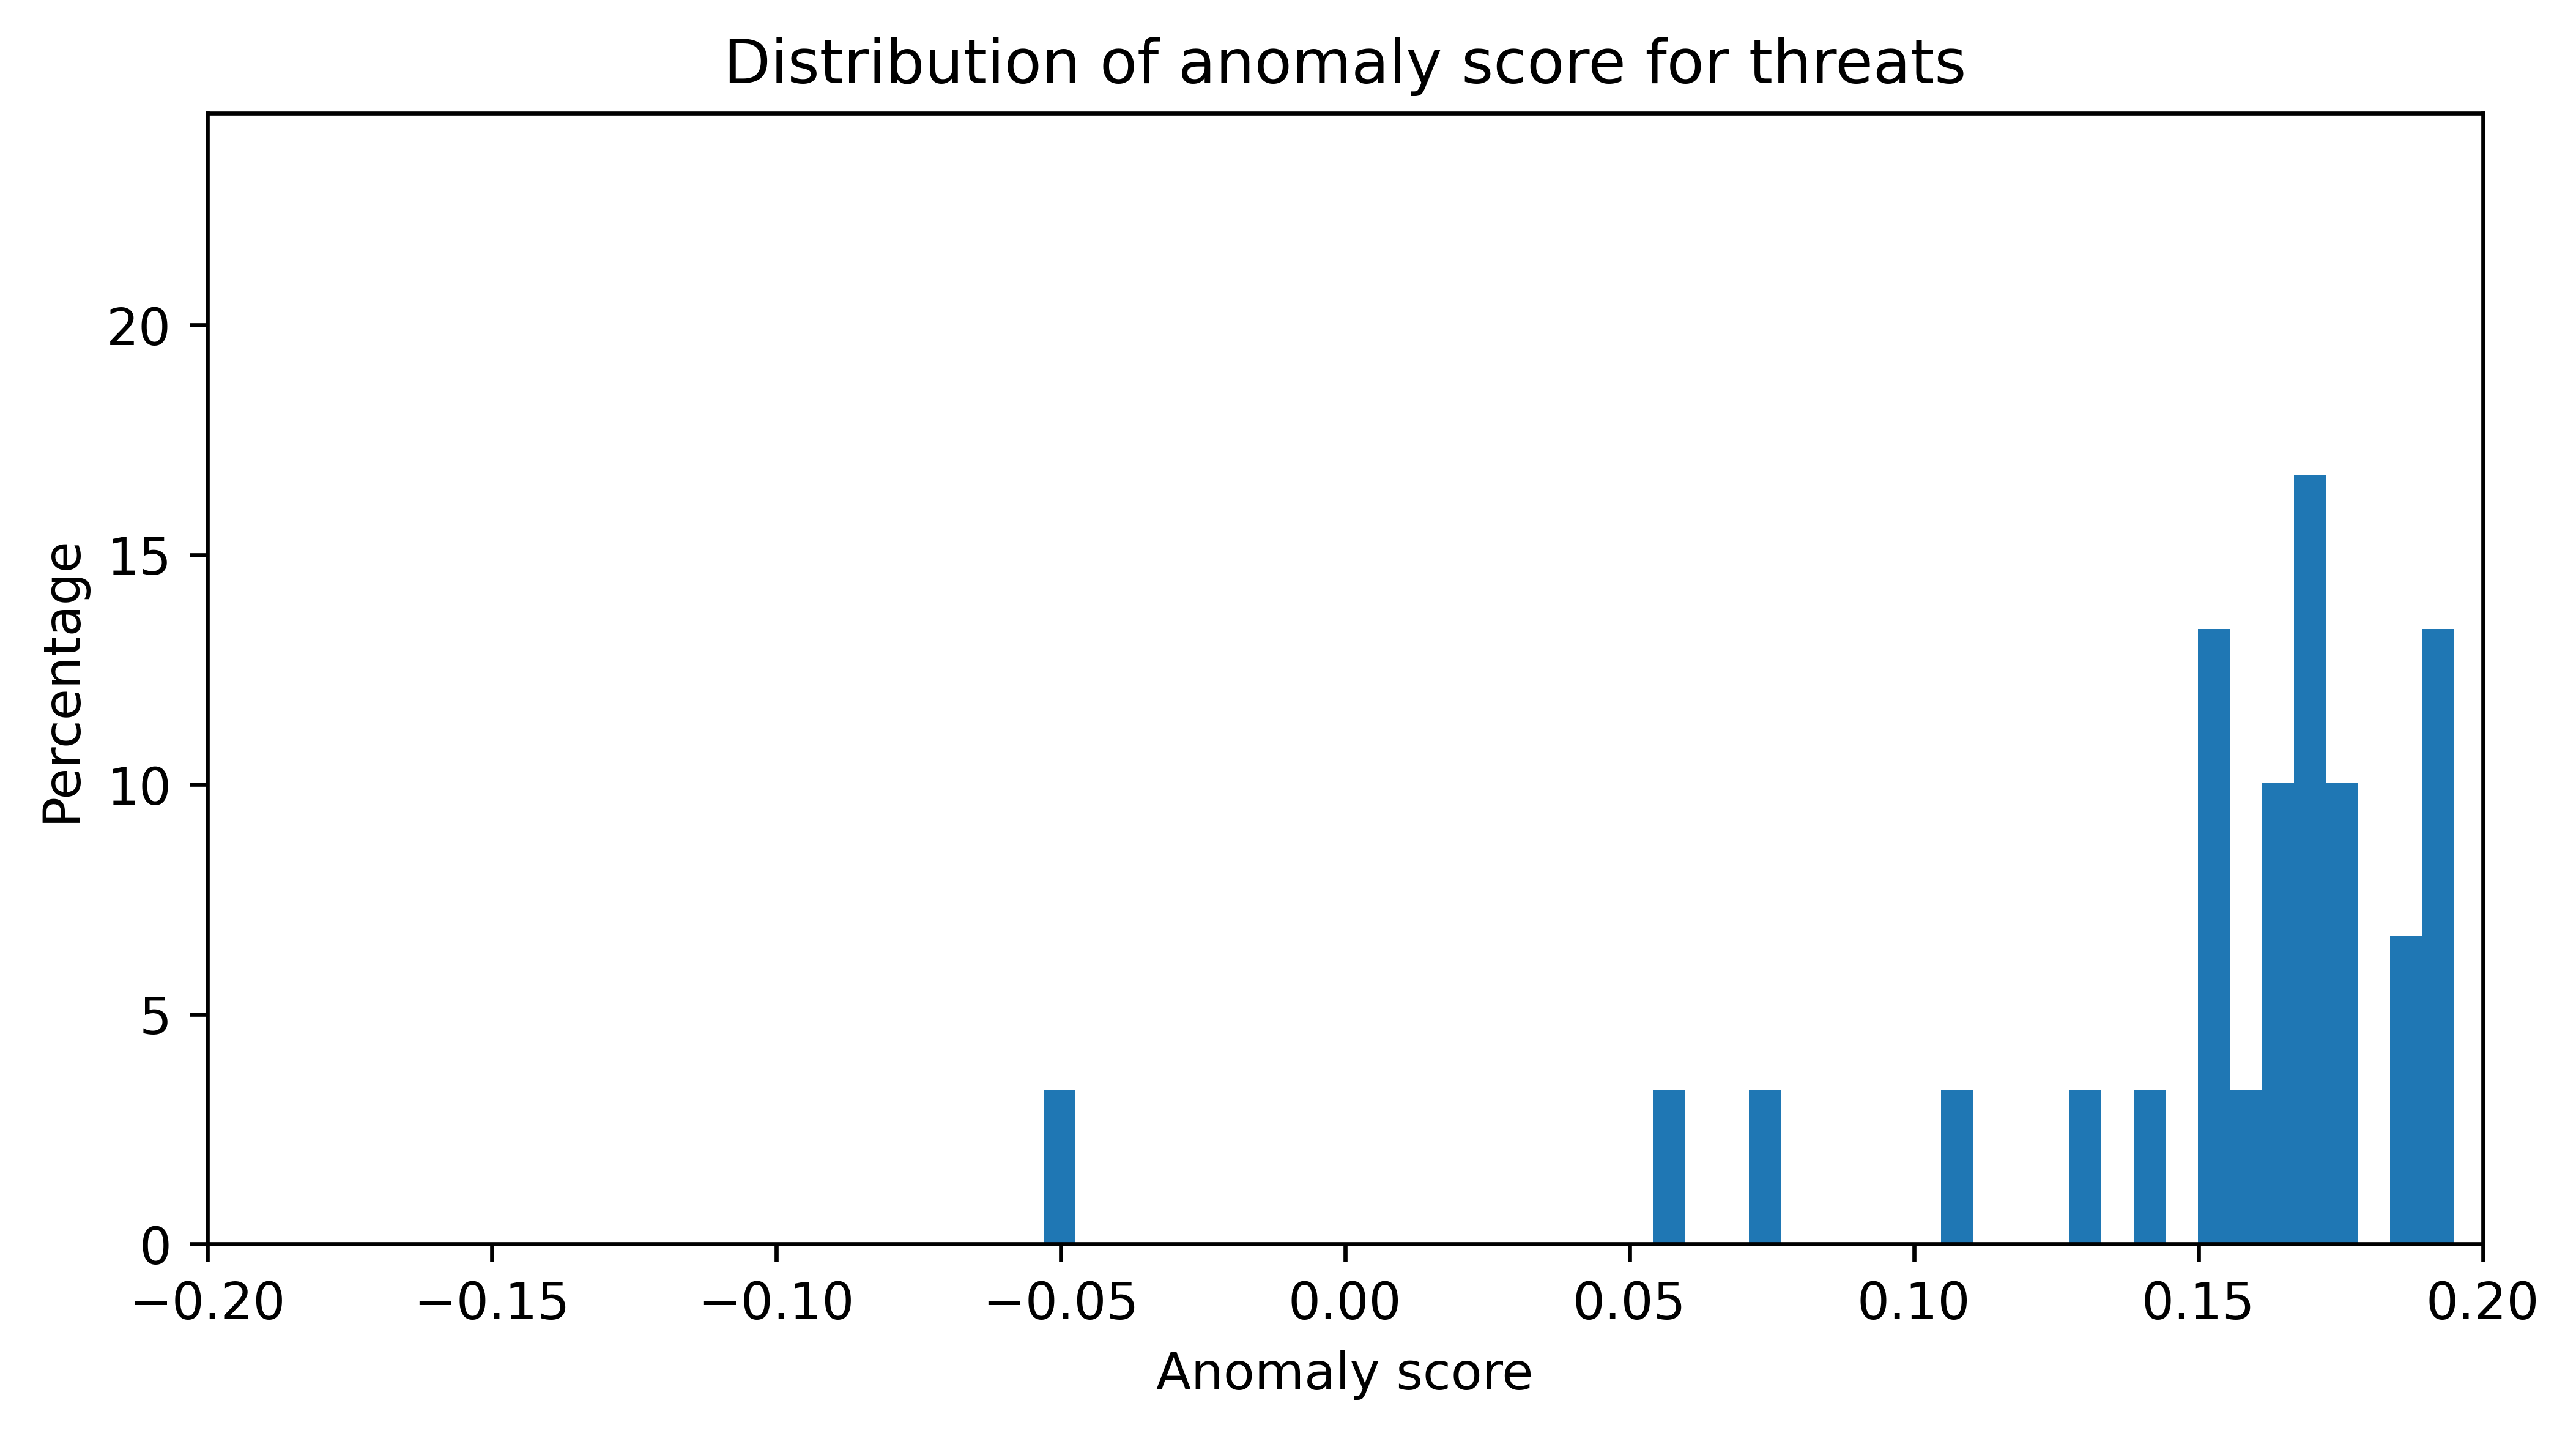

In [61]:
anomaly_scores = IF.decision_function(X_train_threat)

fig = plt.figure(figsize=(8, 4), dpi=600, facecolor="w", edgecolor="k")

anomaly = plt.hist(anomaly_scores, 50, density=True)

plt.xlim((-0.2, 0.2))
plt.xlabel("Anomaly score")
plt.ylabel("Percentage")
plt.title("Distribution of anomaly score for threats")

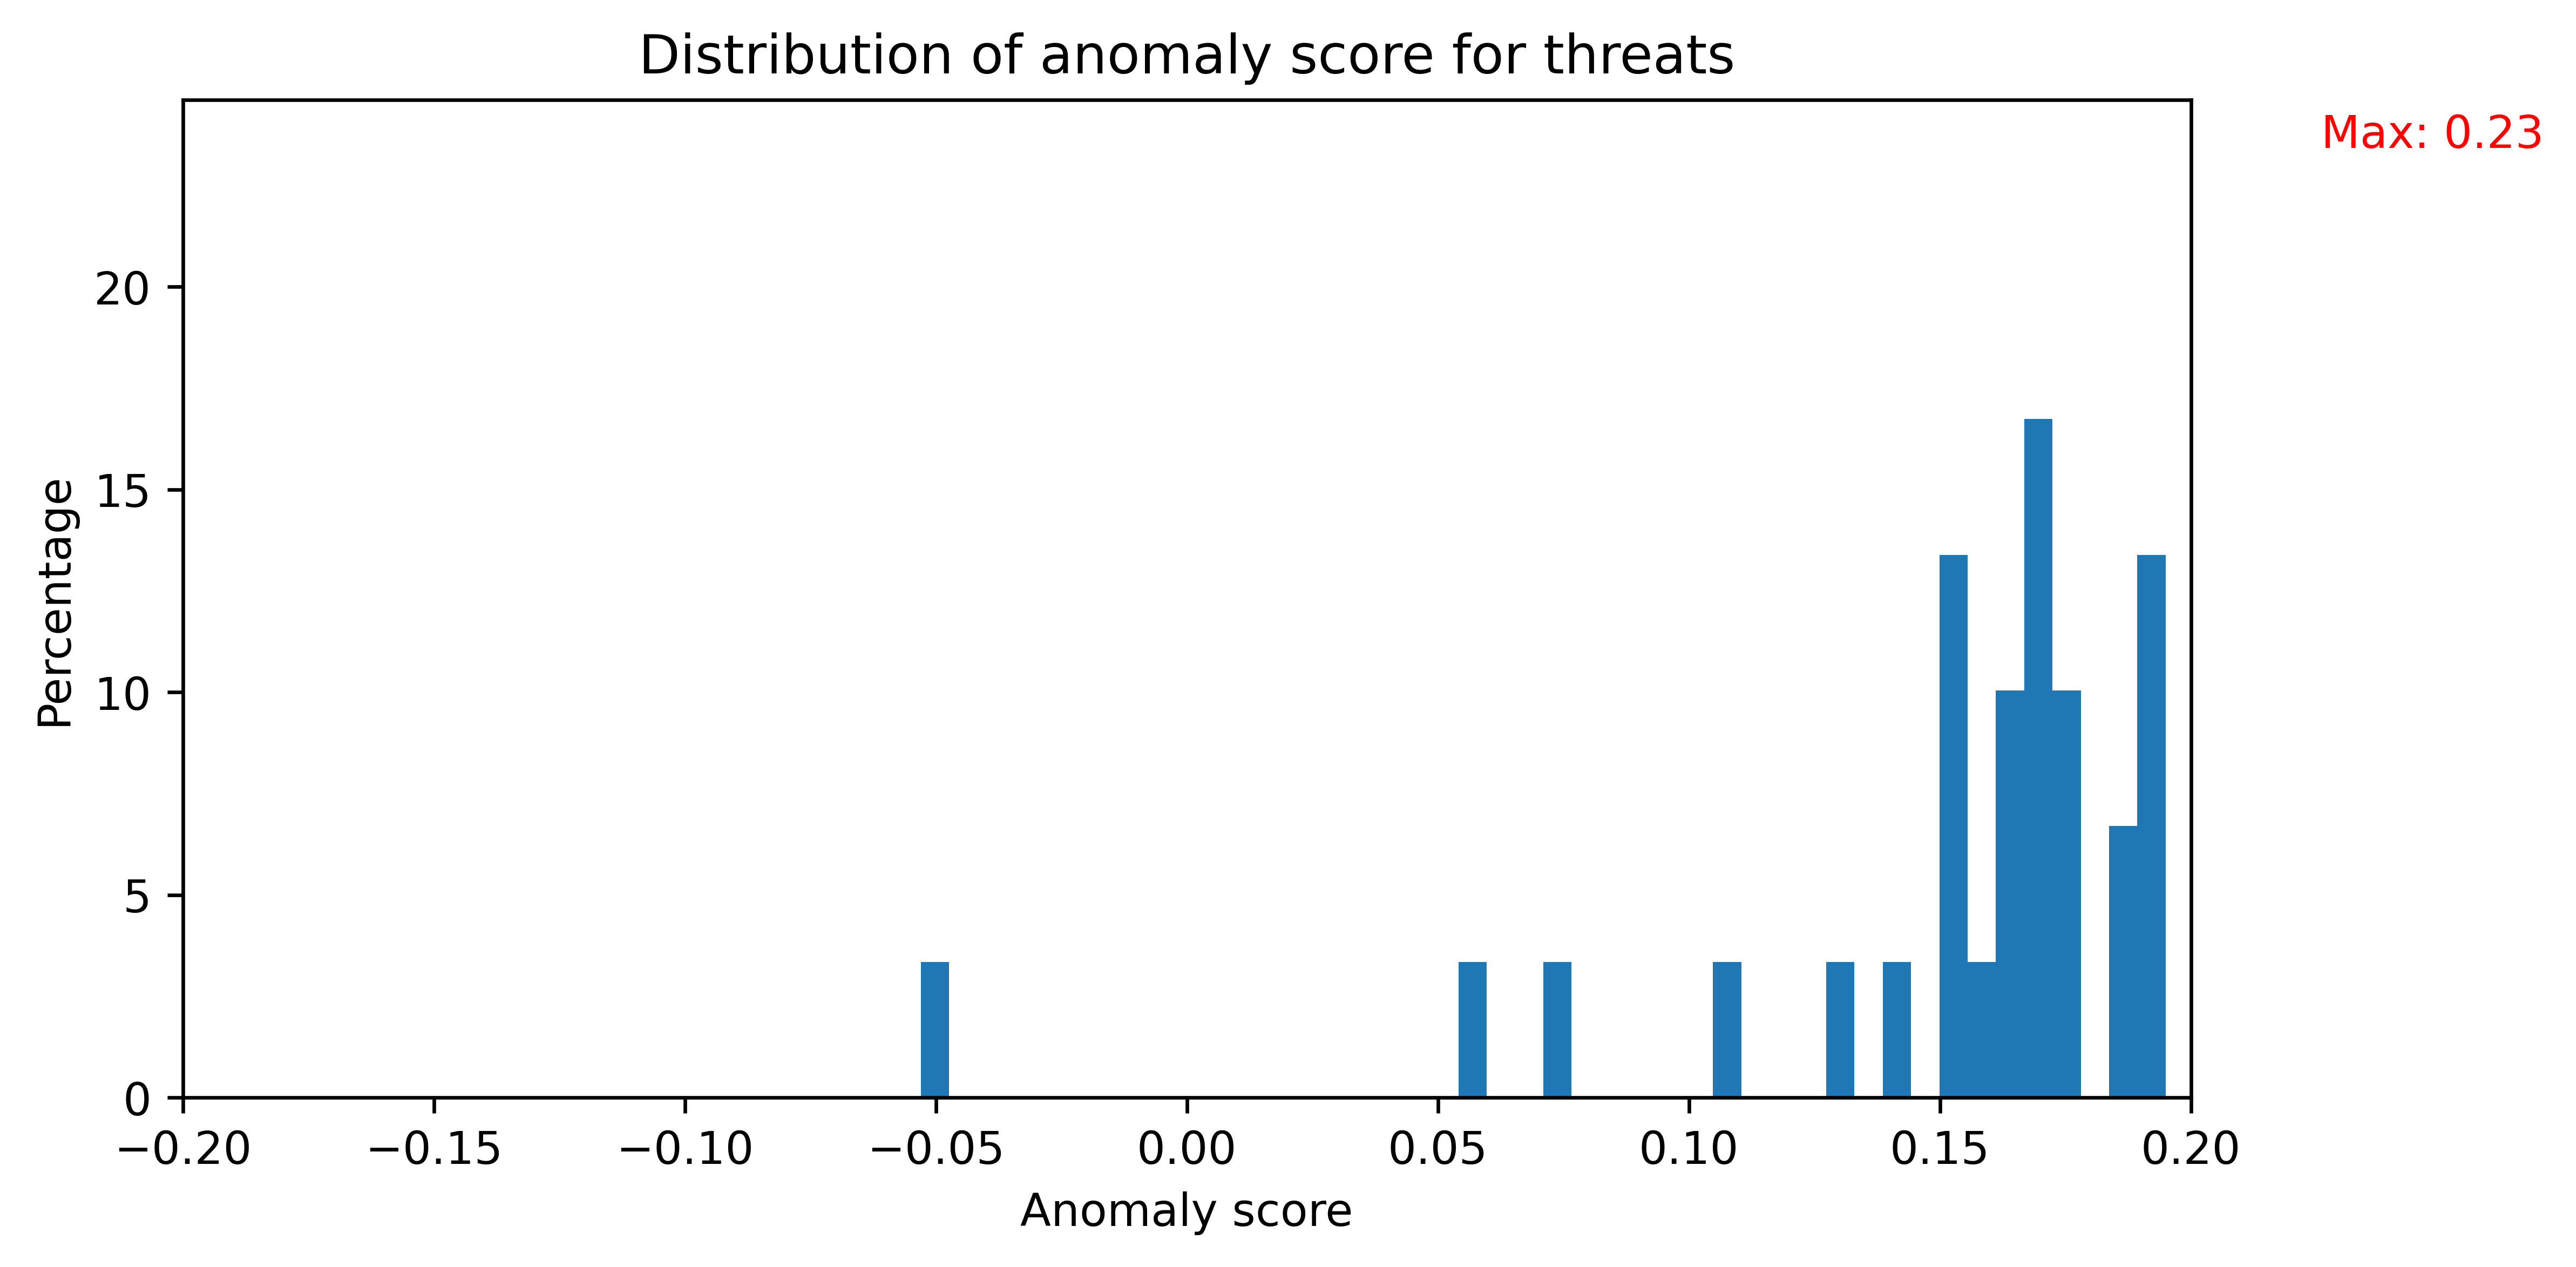

In [62]:
# Step 1: Compute Histogram
# The number of bins can be adjusted as needed
bin_count = 50
hist, bin_edges = np.histogram(anomaly_scores, bins=bin_count, density=True)

# Step 2: Identify Maximum Bin
max_bin_index = np.argmax(hist)
max_bin_value = hist[max_bin_index]
max_bin_center = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2

# Step 3: Plot Histogram
plt.figure(figsize=(8, 4), dpi=600)
plt.hist(anomaly_scores, bins=bin_count, density=True)
plt.xlim((-0.2, 0.2))
plt.xlabel("Anomaly score")
plt.ylabel("Percentage")
plt.title("Distribution of anomaly score for threats")

# Step 4: Mark the Maximum Bin
plt.axvline(x=max_bin_center, color='r', linestyle='dashed', linewidth=2)
plt.text(max_bin_center, max_bin_value, f'Max: {max_bin_center:.2f}', color='red')

plt.show()


Choose a threshold and evaluate results

In [65]:
cutoff = 0.23

from collections import Counter

s = IF.decision_function(X_train_reshaped)
print("training rzlts")
print(Counter(y_train[cutoff > s]))

s = IF.decision_function(X_test_reshaped)
print("testing rzlts")
print(Counter(y_test[cutoff > s]))

training rzlts
Counter({0.0: 486, 1.0: 53})
testing rzlts
Counter({0.0: 158, 1.0: 16})


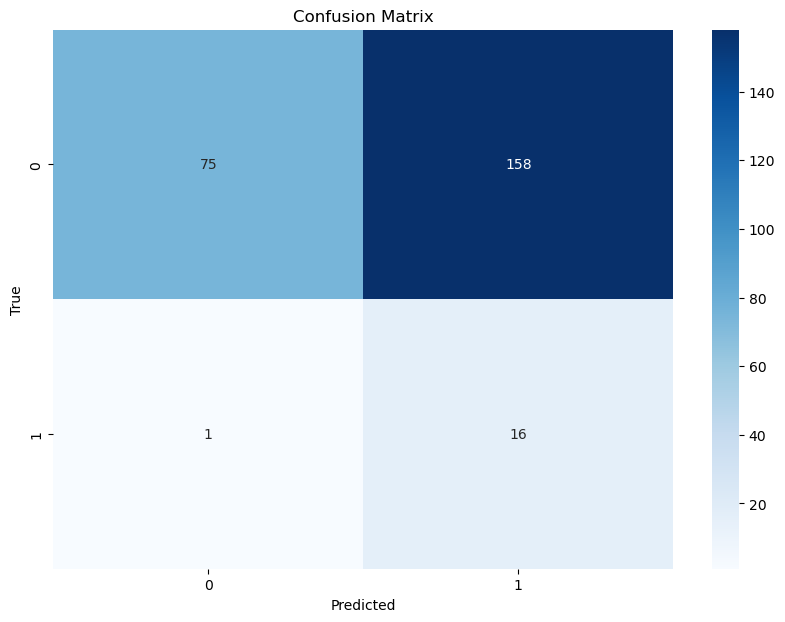

              precision    recall  f1-score   support

         0.0       0.99      0.32      0.49       233
         1.0       0.09      0.94      0.17        17

    accuracy                           0.36       250
   macro avg       0.54      0.63      0.33       250
weighted avg       0.93      0.36      0.46       250



In [66]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Step 1: Compute Predictions
# If the anomaly score is greater than the cutoff, it's a normal case (0), otherwise, it's a threat (1)
predictions = (IF.decision_function(X_test_reshaped) < cutoff).astype(int)

# Step 2: Create Confusion Matrix
cm = confusion_matrix(y_test, predictions)

# Step 3: Calculate Metrics
report = classification_report(y_test, predictions)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(report)


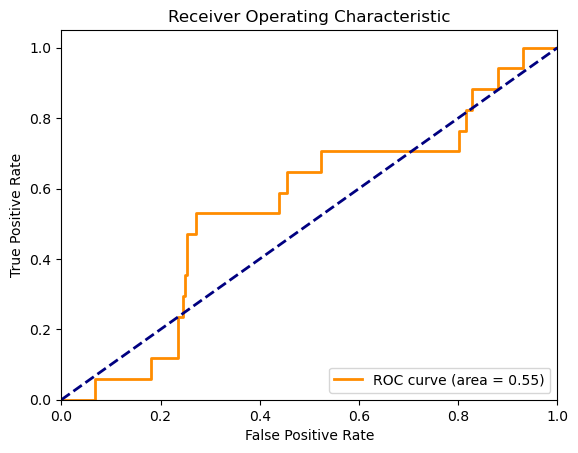

In [67]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, scores)  # scores are from your Isolation Forest model
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

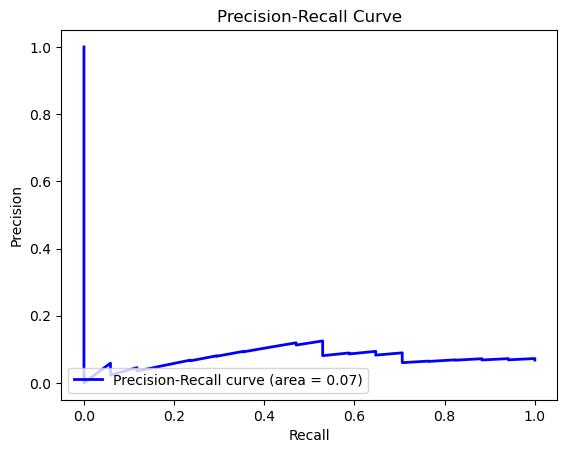

In [68]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, scores)
auprc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
